In [81]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os

from skforecast.model_selection import random_search_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor

/home/lguirald/git/personal/1-environments/api/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [82]:
data = pd.DataFrame(columns=['date', 'indice'])

diretorio = '../data/rl/'

arquivos_json = [arquivo for arquivo in os.listdir(diretorio) if arquivo.endswith('.json')]

for arquivo_json in arquivos_json:
    with open(os.path.join(diretorio, arquivo_json), 'r') as file:
        d = json.loads(file.read())
        
        data_temp = pd.DataFrame({
            'date': d['Indices']['NDVI']['Serie Processada']['Data'],
            'indice': d['Indices']['NDVI']['Serie Processada']['Indice']
        })

        data = pd.concat([data, data_temp], ignore_index=True)

/tmp/ipykernel_118671/730768136.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, data_temp], ignore_index=True)


In [83]:
data

,date,indice
0,2017-08-21,0.018645
1,2017-10-16,0.024464
2,2017-11-09,0.015563
3,2017-11-25,0.003720
4,2017-12-11,0.005570
...,...,...
131,2018-01-09,-0.055066
132,2018-01-25,0.114627
133,2018-03-14,0.653819
134,2018-05-25,0.022128


In [84]:
data.dtypes

date       object
indice    float64
dtype: object

In [85]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [86]:
data = data.set_index('date')
data = data.groupby(data.index).mean()
data = data.asfreq("M",method='backfill')
data = data.sort_index()
data.head(10)

,indice
date,
2017-07-31,0.009194
2017-08-31,0.000717
2017-09-30,0.018780
2017-10-31,0.000315
2017-11-30,0.017883
2017-12-31,0.088264
2018-01-31,0.011017
2018-02-28,0.008140
2018-03-31,0.007450


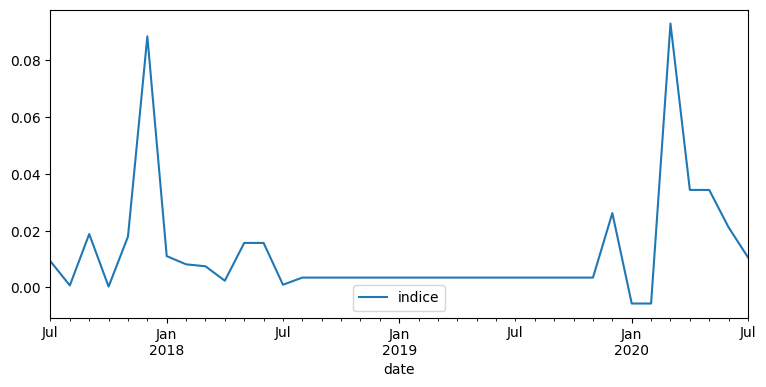

In [87]:
fig, ax = plt.subplots(figsize=(9, 4))
data['indice'].plot(ax=ax, label='indice')
ax.legend()

Model validation    

Train dates : 2017-07-31 00:00:00 --- 2019-09-30 00:00:00  (n=27)
Test dates  : 2019-10-31 00:00:00 --- 2020-07-31 00:00:00  (n=10)


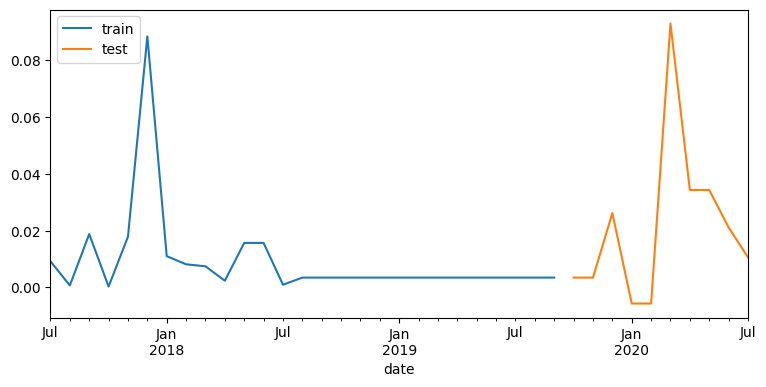

In [88]:
steps = 10

data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# Plotando os dados
fig, ax=plt.subplots(figsize=(9, 4))
data_train['indice'].plot(ax=ax, label='train')
data_test['indice'].plot(ax=ax, label='test')
ax.legend();

In [91]:
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 10 # O valor será substituído durante o tunning
             )

# Valores de lag a testar
lags_grid = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Regressor hyperparameters
param_distributions = {'n_estimators': np.arange(start=10, stop=100, step=1, dtype=int),
                       'max_depth': np.arange(start=5, stop=30, step=1, dtype=int)}

results = random_search_forecaster(
              forecaster           = forecaster,
              y                    = data['indice'],
              steps                = steps,
              lags_grid            = lags_grid,
              param_distributions  = param_distributions,
              n_iter               = 100,
              metric               = 'mean_squared_error',
              refit                = True,
              initial_train_size   = len(data['indice']) - steps,
              fixed_train_size     = False,
              return_best          = True,
              random_state         = 123,
              verbose              = False
          )

results

Number of models compared: 900.


lags grid: 100%|██████████| 9/9 [00:59<00:00,  6.66s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2] 
  Parameters: {'n_estimators': 28, 'max_depth': 5}
  Backtesting metric: 0.0010890816711199226



,lags,params,mean_squared_error,n_estimators,max_depth
31,"[1, 2]","{'n_estimators': 28, 'max_depth': 5}",0.001089,28,5
25,"[1, 2]","{'n_estimators': 60, 'max_depth': 5}",0.001090,60,5
13,"[1, 2]","{'n_estimators': 43, 'max_depth': 5}",0.001090,43,5
562,"[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 40, 'max_depth': 19}",0.001092,40,19
545,"[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 75, 'max_depth': 27}",0.001092,75,27
...,...,...,...,...,...
48,"[1, 2]","{'n_estimators': 20, 'max_depth': 7}",0.001092,20,7
80,"[1, 2]","{'n_estimators': 30, 'max_depth': 6}",0.001092,30,6
131,"[1, 2, 3]","{'n_estimators': 28, 'max_depth': 5}",0.001093,28,5
113,"[1, 2, 3]","{'n_estimators': 43, 'max_depth': 5}",0.001093,43,5
